In [5]:
import csv
import os
import pandas as pd
import numpy as np
from numba import njit ## PARA CUADERNOS EN GOOGLE COLAB

In [6]:
def load_mats(path, verbose=False):
    """
    Leer archivos .dat
        1ra matriz -> distancias
        2da matriz -> flujos
    """
    try:
        with open(path, "r") as file:
            lines = file.readlines()
            try:
                mat_size = int(lines[0].strip())
                if (verbose): print(f"mat_size={mat_size}")

                n_mats = int((len(lines)-1) / mat_size)
                if (verbose): print(f"nmats={n_mats}")
                mats = np.zeros((n_mats, mat_size, mat_size), dtype=np.int32)
                for idx_mat in range(n_mats):
                    for i in range(1, mat_size+1):
                        elements = list(filter(None, lines[idx_mat*mat_size + i].strip().split(' ')))
                        if elements:
                            if len(elements) != mat_size:
                                print(f"Matriz irregular [{len(elements)} != {mat_size}] en {path} (linea {idx_mat*mat_size + i})\nDetail:\n{elements}")
                                return dict()
                            for j in range(len(elements)):
                                if elements[j]:
                                    mats[idx_mat, i-1, j] = np.int32(elements[j])
                return {"nombre" : path, "distancia" : mats[0, :, :], "flujo" : mats[1, :, :]}
            except ValueError:
                print("ValueError")
            except:
                print(f"Error al parsear {path}")
    except:
        print(f"Archivo {path} no existe")

    return dict()

def save(path, solucion, valor, iteraciones):
    try:
        file = open(path, "w")

        file.write(f"{valor} {iteraciones}\n")
        for el in solucion:
            file.write(f"{el} ")
        file.write("\n")
    except:
        print(f"Unable to write file {path}")

# Funcion objetivo de kevin
def funcion_objetivo_kevin(solucion, matD, matF):
    permutado = matF[solucion, :][:, solucion]
    return np.sum(np.multiply(matD, permutado), dtype=np.int32)

@njit
def funcion_objetivo(solucion, matD, matF):
    result = 0
    n = matD.shape[0]

    for i in range(n):
        for j in range(n):
                if i != j:
                    result += matD[i, j] * matF[solucion[i] , solucion[j] ]
    return result

@njit
def delta(S, d, f, r, s):
    n = len(S)
    delta_val = 0
    for k in range(n):
        if k == r or k == s:
            continue
        delta_val += (
            d[r][k] * (f[S[r]][S[k]] - f[S[s]][S[k]]) +
            d[k][r] * (f[S[k]][S[r]] - f[S[k]][S[s]]) +
            d[s][k] * (f[S[s]][S[k]] - f[S[r]][S[k]]) +
            d[k][s] * (f[S[k]][S[s]] - f[S[k]][S[r]])
        )
    delta_val += (
        d[r][s] * (f[S[r]][S[s]] - f[S[s]][S[r]]) +
        d[s][r] * (f[S[s]][S[r]] - f[S[r]][S[s]])
    )
    return delta_val

def delta_numpy(S, d, f, r, s):
    S = np.asarray(S)
    n = len(S)

    k = np.array([k for k in range(n) if k != r and k != s])

    # Preextraer ubicaciones
    Sr, Ss = S[r], S[s]
    Sk = S[k]

    # Vectorizados
    term1 = d[r, k] * (f[Sr, Sk] - f[Ss, Sk])
    term2 = d[k, r] * (f[Sk, Sr] - f[Sk, Ss])
    term3 = d[s, k] * (f[Ss, Sk] - f[Sr, Sk])
    term4 = d[k, s] * (f[Sk, Ss] - f[Sk, Sr])

    # Suma total de los cuatro vectores
    delta_val = np.sum(term1 + term2 + term3 + term4, dtype=np.int32)

    # Términos fuera del bucle
    delta_val += d[r][s] * (f[Sr][Ss] - f[Ss][Sr]) + d[s][r] * (f[Ss][Sr] - f[Sr][Ss])

    return delta_val

def operador_sublista_aleatoria(solucion, s : int):
    """
    Operador de generacion de vecino -> Sublista Aleatoria de Tamaño Fijo:
    este proceso consiste en generar aleatoriamente dos posiciones
     que determinen una sublista de tamaño s, analizar las asignaciones
    efectuadas entre ambas y reasignarlas aleatoriamente. Se considerarán
    sublistas cíclicas y, por tanto, la posición inicial de la sublista
    no siempre será inferior a la posición final.
    """
    n = len(solucion)
    inicio = np.random.randint(n)

    # Crear los índices cíclicos de la sublista
    indices = [(inicio + i) % n for i in range(s)]

    # Extraer y mezclar la sublista
    sublista = [solucion[i] for i in indices]
    shuffled = sublista.copy()
    while shuffled == sublista:
        np.random.shuffle(shuffled)

    # Reinsertar la sublista mezclada
    nueva_solucion = solucion.copy()
    for idx, val in zip(indices, shuffled):
        nueva_solucion[idx] = val

    return nueva_solucion

def vector_to_str(vct : list) -> str:
    s = " "
    for e in vct:
        s = s + str(e) + " "

    return s


class Logger:

    def __init__(self, ruta_csv, overwrite=True):
        self.ruta_csv = ruta_csv
        self.dataset = None

        # Crear archivo con cabecera
        if overwrite or not os.path.exists(self.ruta_csv):
            with open(self.ruta_csv, mode='w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(["Dataset", "Algoritmo", "Semilla", "Costo", "Evaluaciones", "Solucion"])
        else:
            self.data = pd.read_csv(self.ruta_csv)

    def set_dataset(self, dataset):
        self.dataset = dataset

    def log(self, algoritmo, semilla, costo, evaluaciones, solucion):
        if not self.dataset:
            raise Exception("Dataset not set!")
        fila = [
            self.dataset,
            algoritmo,
            semilla,
            costo,
            evaluaciones,
            solucion
        ]

        with open(self.ruta_csv, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(fila)

In [7]:
############ BUSQUEDA LOCAL
def bl_primer_mejor(solucion_actual, matD, matF, delta, valor_fo=None, funcion_objetivo=None):
    """
    Se hace la busqueda local del primer mejor
    No hay componentes aleatorias
    """
    n_nodes = matD.shape[0]

    mejor_solucion = solucion_actual
    mejor_valor = valor_fo
    if not valor_fo:
        mejor_valor = funcion_objetivo(mejor_solucion, matD, matF)

    evals = 0

    while True:

        encontrado = False
        for i in range(n_nodes - 1):
            for j in range(i + 1, n_nodes):
                valor_vecino = mejor_valor - delta(mejor_solucion, matD, matF, i, j)
                #valor_vecino = funcion_objetivo(vecino, matD, matF)
                evals += 1
                #print(evals)

                if valor_vecino < mejor_valor:
                    mejor_solucion[i], mejor_solucion[j] = mejor_solucion[j], mejor_solucion[i]
                    mejor_valor = valor_vecino
                    encontrado = True
                    break

            if encontrado:
                break

        if not encontrado:
            break

    return mejor_solucion, mejor_valor, evals

In [8]:
sko90 = load_mats("datasets/sko90b.dat")
n = sko90['distancia'].shape[0]
matD = sko90['distancia']
matF = sko90['flujo']

In [16]:
def ILS_poblacional(matD, matF, k, seed, logger : Logger = None):
    # Init semilla
    np.random.seed(seed)

    n = matD.shape[0]
    s = int(np.round(n/4))
    evaluaciones = 0
    iters = 0
    soluciones_actual = [np.random.permutation(n) for _ in range(k)]
    valores_actual = [funcion_objetivo(s, matD, matF) for s in soluciones_actual]
    costos_iteracion = []
    # generado por copilot: valor_delta = lambda r, s: delta(solucion_actual, matD, matF, r, s)

    soluciones_mejor = soluciones_actual.copy()
    valores_mejor = valores_actual.copy()

    """
    PARA HACER ILS POBLACIONAL:
    HACER UN VECTOR DE SOLUCIONES : [s1, s2, s3 .. sK]
    Optimizar cada solucion con busqueda local y luego seleccionar y obtener el vector final:

    vector final = [mejor(s1, s1_opt), .. mejor(sK, sK_opt)]
    """

    num_no_mejora = 0

    #while num_no_mejora < 10:
    while iters < 100:
        iters += 1
        print(iters)
        costos = []
        mejora = False
        for idx_k in range(k):
            solucion_actual = soluciones_actual[idx_k]
            solucion_optimizada, valor_optimizado, evals = bl_primer_mejor(solucion_actual, matD, matF, delta, valor_fo=funcion_objetivo(solucion_actual, matD, matF))
            evaluaciones += evals

            if valor_optimizado < valores_mejor[idx_k]:
                soluciones_mejor[idx_k] = solucion_optimizada
                valores_mejor[idx_k] = valor_optimizado
                mejora = True

            costos.append(valores_mejor[idx_k])
            # Hacer mutacion sobre mejor_solucion
            solucion_actual = operador_sublista_aleatoria(soluciones_mejor[idx_k], s)
            soluciones_actual[idx_k] = solucion_actual

        costos_iteracion.append(costos)
        if not mejora:
            num_no_mejora += 1
        else:
            num_no_mejora = 0

    return soluciones_mejor, valores_mejor, evaluaciones, costos_iteracion

In [17]:
solucion10, valor10, evaluaciones10, costos_iteracion10 = ILS_poblacional(matD, matF, 10, 42)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [18]:
solucion20, valor20, evaluaciones20, costos_iteracion20 = ILS_poblacional(matD, matF, 20, 42)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


seed = 42

ILS clasico (deberia ser k=1)

[26, 10, 21, 39, 86, 78, 76, 63, 66,  4, 58, 70, 33, 60, 43, 56, 73,
       16, 81, 24, 17, 29, 22, 11, 80, 62, 77, 57, 42, 19, 68, 59, 83, 67,
       65,  5, 50, 13,  0, 61, 45, 35, 36, 64, 53, 18, 12, 20, 28, 52, 74,
       48, 25, 89, 27, 79,  2, 72, 31, 32, 55, 69, 87,  3, 46, 82, 14, 54,
       38, 34, 47, 44,  9, 88, 84,  6, 51, 37, 71, 41, 85, 49,  8, 30, 75,
       40, 15,  7,  1, 23]

116280


[array([21, 10, 68, 39, 11, 78, 76, 86, 63,  4, 33, 70,  9, 60, 56, 73, 80,
        16, 24, 66, 22, 58, 59, 43, 18, 62, 77, 37, 20, 57, 29, 17, 83, 65,
         5, 82, 12, 13,  0, 23, 30, 45, 14, 36, 53, 25, 89, 72,  3, 28, 49,
        55, 35, 67, 27, 50, 88, 42, 52, 81,  8, 74, 48, 40, 79, 64, 84, 61,
        54, 41, 47, 44, 69,  6,  2, 15, 19, 34, 38,  1, 85, 26, 87, 75, 46,
        51, 32, 31, 71,  7]),
 array([17, 29, 44, 58, 25, 49, 45, 74, 47, 26, 70, 22, 59,  8, 48, 83, 55,
        87, 85, 10, 21, 68, 11, 35, 67,  2, 50, 60, 39, 76, 33,  6, 56, 18,
        36, 27, 77, 79, 43, 78, 30, 16,  5, 14, 37, 65, 12, 62, 51, 40, 24,
        54, 82, 88, 53, 13, 73, 42, 15, 75, 52, 34, 69, 46, 84, 89, 64, 31,
        32, 19, 66,  1,  9,  3, 38, 72, 80, 57, 61, 86,  4, 41, 63, 28, 20,
        71,  0, 23,  7, 81]),
 array([85, 55, 17, 45, 19, 32,  7, 23, 66,  4, 47, 30, 44, 54, 82, 84, 34,
        38, 61, 41, 49, 59,  9, 88, 27, 31, 71, 25, 72,  1,  8, 69, 15,  2,
        67, 53, 89,  3, 20, 28, 75, 35, 79,  6, 36, 46, 64,  0, 80, 52, 40,
        48, 14, 18,  5, 51, 37, 12, 76, 81, 74, 68, 87, 11, 50, 62, 13, 42,
        73, 63, 26, 58, 29, 83, 56, 65, 77, 57, 16, 78, 10, 22, 70, 33, 21,
        43, 39, 60, 86, 24]),
 array([21, 68, 78, 76, 11, 81, 19, 86, 63,  4, 33, 70, 56, 64, 39, 77, 80,
        16, 24, 66, 52, 43, 18, 12,  5, 13,  9, 28, 61, 41, 30, 14,  6, 36,
        65, 62, 31, 72, 34, 38, 75, 40, 15, 79, 51, 46, 32, 88, 54,  1, 49,
        69, 42, 27, 50, 82, 73, 84,  0, 20, 22, 29, 48, 35,  2, 37, 89, 67,
        57, 71, 85, 58,  8, 87, 83, 53, 59,  3, 60,  7, 26, 47, 74, 55, 44,
        45, 25, 17, 10, 23]),
 array([26, 44, 48, 74, 45, 25, 17, 29, 10, 22, 85, 47, 49, 55, 35, 53, 59,
        58, 68, 70, 87, 84, 30,  8, 67,  3, 83, 60, 39, 33, 69, 46,  6, 27,
        36, 50, 65, 43, 11, 21, 75, 40,  2, 79, 88, 89, 82, 37, 56, 73, 51,
        34, 15, 64, 14,  9,  5, 62, 18, 78, 31, 38, 71, 54, 12, 72, 80, 77,
        76, 86, 19, 61, 52, 42,  0, 20, 13, 16, 63, 24, 32, 41,  1, 81, 28,
         7, 23, 57, 66,  4]),
 array([33, 68, 70, 60, 78, 73, 16, 10, 66,  4, 21, 58, 43, 83, 56, 11, 39,
        76, 63, 24, 22, 29, 65, 77, 62,  5, 59,  9, 80, 17,  8, 14, 18, 12,
         6, 82, 37, 88, 54, 30, 49, 40, 48, 36, 79, 27, 89, 72, 20, 52, 55,
        35, 57, 50, 53, 25, 67,  3, 28,  1, 47, 74, 42, 15,  2, 45, 13,  0,
        38, 23, 85, 69, 87, 64, 46, 44, 84, 71, 34, 41, 26, 75, 81, 32, 31,
        51, 86, 19, 61,  7]),
 array([ 7, 32, 81, 19, 71, 38, 23, 41, 66,  4, 51, 31, 42, 54, 37, 34, 61,
        20,  1, 24, 75, 15, 40,  0, 13, 82, 84, 72, 73, 16, 57,  2, 79, 12,
        62,  5, 53, 28, 76, 78, 18, 50, 64, 46, 27, 77, 89, 25, 80, 86, 69,
         6, 35, 36, 56, 88, 67,  3, 60, 63, 87, 48, 14, 65, 43, 83, 59, 52,
        39, 10, 68, 74, 55, 29, 58, 11, 45, 17, 70, 22, 85, 26, 47, 49,  8,
        44, 30,  9, 33, 21]),
 array([85, 26, 55, 74, 47, 44, 45, 25, 17,  7,  8, 87, 48, 58, 49, 83, 37,
        59, 30, 23, 68, 40, 79, 29, 27,  2, 89, 88, 72, 54, 18, 14, 36,  6,
        51,  5, 53,  9, 31, 38, 69, 46, 32, 65, 39, 12, 82, 84,  3, 34, 75,
        35, 56, 43, 62, 77, 57, 80, 28, 66, 11, 64, 15, 50, 42, 13,  0, 20,
        61, 41, 22, 86, 76, 19, 67, 60, 81, 71, 52,  1, 21, 78, 10, 70, 33,
        16, 73, 63, 24,  4]),
 array([21, 33, 68, 69, 18, 58,  8, 75, 85, 26, 22, 29, 11, 14, 64, 35, 48,
        40, 74, 47, 70, 30, 46,  6, 36, 50, 56, 78, 87, 55, 86, 54, 82, 83,
        77,  2, 27, 15, 79, 49, 24, 16,  5, 65, 12, 13, 37, 43, 42, 51, 19,
        61, 34, 84, 53, 67, 73, 60, 62, 39, 17,  9, 80, 88, 31, 59, 44, 76,
        32, 10, 66, 63, 38, 72, 28,  0, 89, 20, 81, 45,  4,  1, 41,  3, 52,
        71, 25, 57, 23,  7]),
 array([85, 74, 15, 49, 42, 44, 32, 19, 52, 41, 26, 87, 48, 55, 79, 25, 45,
        31, 81, 23, 47, 51,  6, 50,  2, 27, 53, 84, 34,  7, 10, 75, 76, 35,
        57, 67, 89, 72, 28, 71, 43, 39, 69, 65, 62, 59, 64, 88,  0, 38, 60,
        83, 40, 14, 13, 36, 46,  3, 61, 20, 58,  8, 56, 18, 37, 12,  5,  9,
        54,  1, 21, 22, 68, 11, 77, 73, 82, 80, 63, 66, 33, 70, 78, 29, 16,
        30, 17, 86, 24,  4])]

[115918,
 116844,
 116160,
 116572,
 116452,
 116362,
 116374,
 116568,
 116578,
 116294]

In [11]:
valor

NameError: name 'valor' is not defined

In [ ]:
min(valor20)

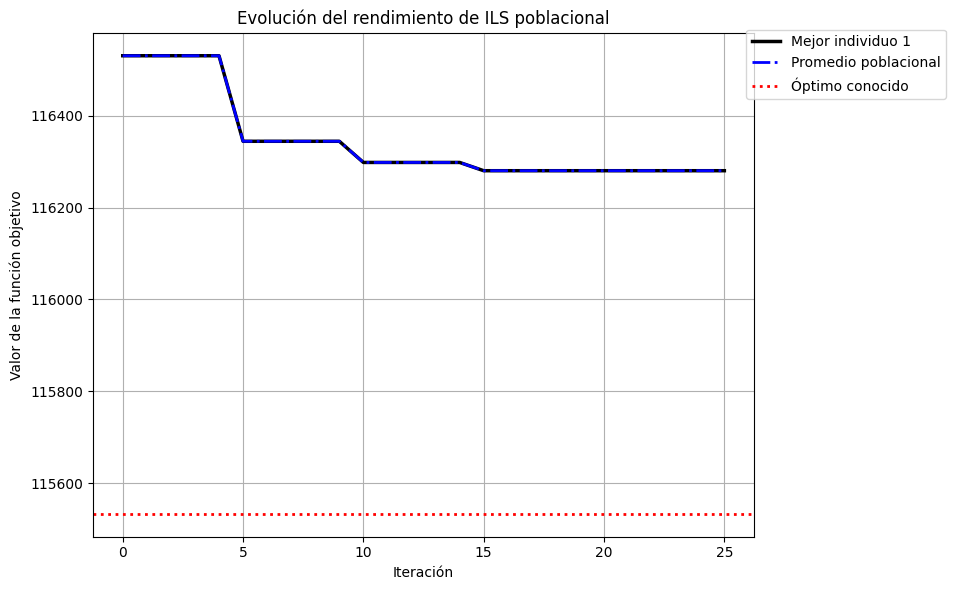

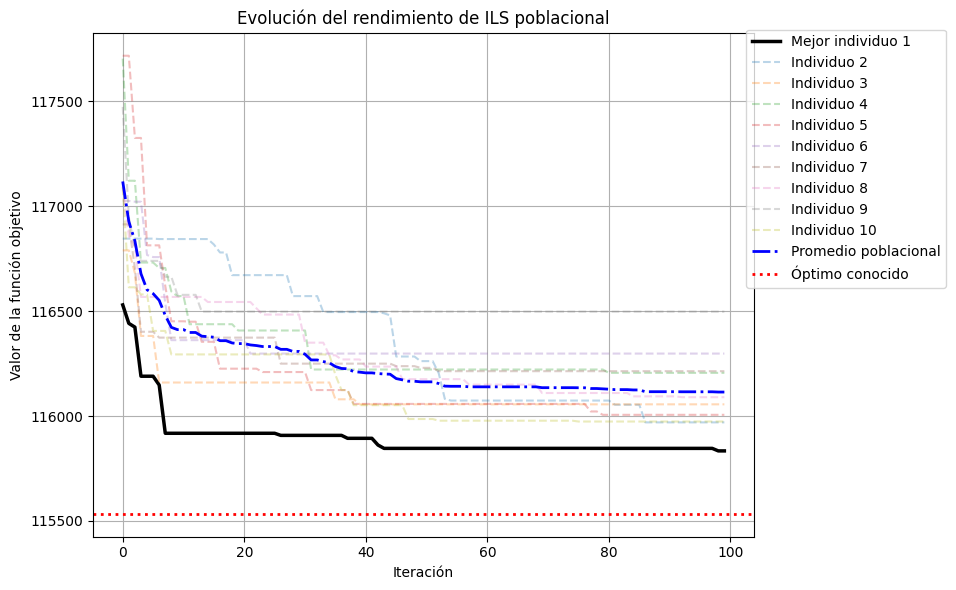

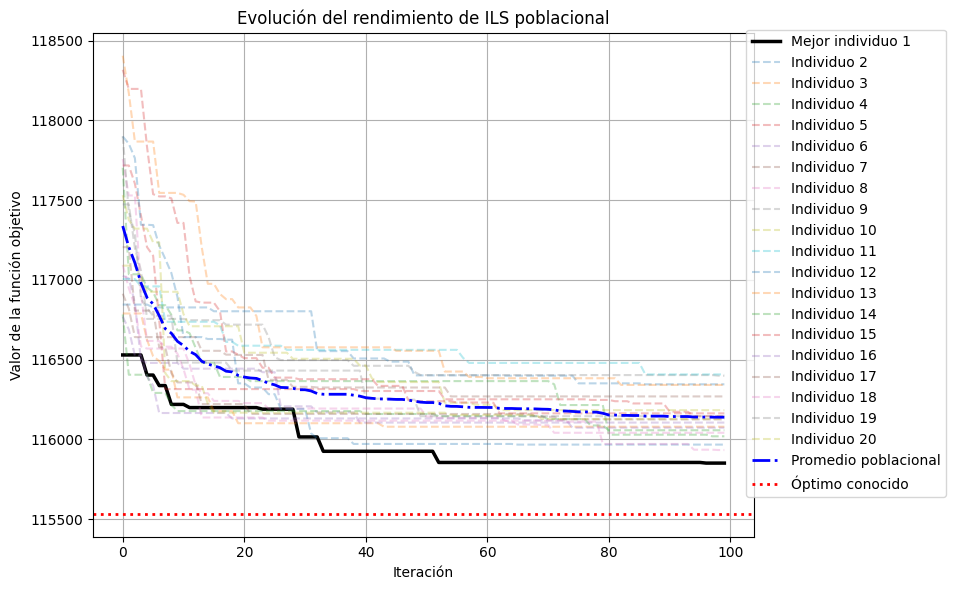

In [19]:
import matplotlib.pyplot as plt
def plot_rendimiento_ils_poblacional(optimo, valores):
    """
    Plotea la evolución del rendimiento del ILS poblacional mostrando cada individuo.

    Parámetros:
    - optimo: float, valor óptimo de referencia.
    - valores: numpy.ndarray, matriz de tamaño (n_iteraciones, k_población)
    """
    valores = np.array(valores)

    n_iteraciones, k_poblacion = valores.shape

    # Índice del mejor individuo según el valor final (última iteración)
    #indice_mejor = np.argmin(valores[-1, :])

    indice_mejor = np.argmin(np.min(valores, axis=0))

# Calcular el promedio por iteración
    promedio = np.mean(valores, axis=1)

    plt.figure(figsize=(10, 6))

    # Dibujar todos los individuos
    for i in range(k_poblacion):
        if i == indice_mejor:
            plt.plot(valores[:, i], label=f'Mejor individuo {i+1}', linewidth=2.5, color='black')
        else:
            plt.plot(valores[:, i], label=f'Individuo {i+1}', alpha=0.3, linestyle='--')

    # Línea del promedio
    plt.plot(promedio, label='Promedio poblacional', color='blue', linewidth=2, linestyle='-.')

    # Línea del óptimo
    plt.axhline(optimo, color='red', linestyle=':', linewidth=2, label='Óptimo conocido')

    plt.xlabel('Iteración')
    plt.ylabel('Valor de la función objetivo')
    plt.title('Evolución del rendimiento de ILS poblacional')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.02))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_rendimiento_ils_poblacional(115534, costos_iteracion1)
plot_rendimiento_ils_poblacional(115534, costos_iteracion10)
plot_rendimiento_ils_poblacional(115534, costos_iteracion20)

In [ ]:
valores = np.array(costos_iteracion)
np.min(np.min(valores, axis=1))

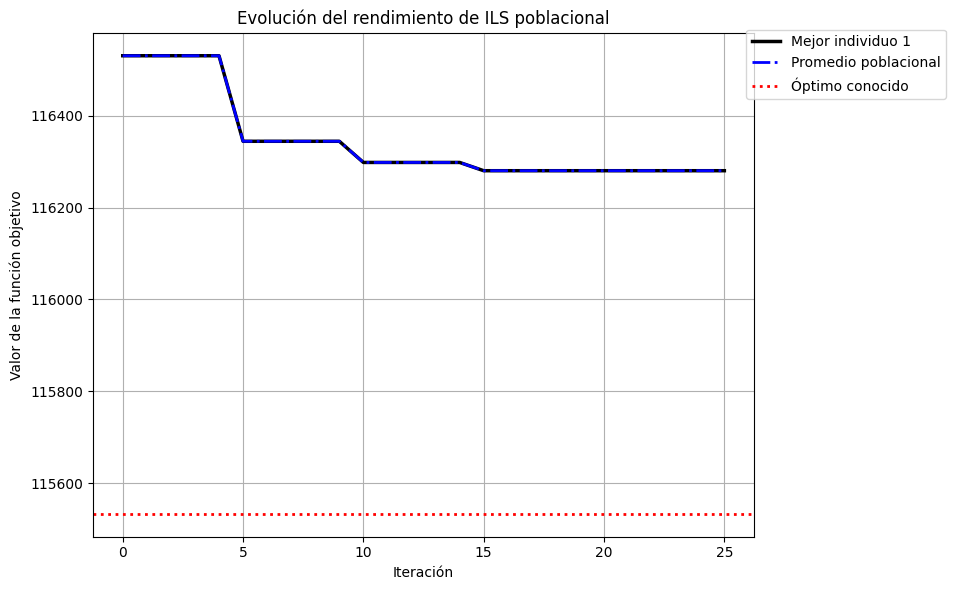

In [20]:
plot_rendimiento_ils_poblacional(115534, costos_iteracion1)

In [34]:
def VNS(matD, matF, seed):
    # Init semilla
    np.random.seed(seed)

    n = matD.shape[0]
    k_max = 5
    bl_max = 10
    k = 1
    bl = 0

    mejor_solucion = np.random.permutation(n)
    mejor_valor = funcion_objetivo(mejor_solucion, matD, matF)
    evaluaciones = 0
    valores = []
    # Paso 6
    num_no_mejora = 0
    cambios = []
    num_vecindario_explorado = 0
    evals_vecindario = []
    while num_no_mejora < 10:
        # Paso 2
        if k > k_max:
            k = 1
        # Paso 3
        s = int(np.round(n / (9 - k)))
        vecino = operador_sublista_aleatoria(mejor_solucion, s)
        # Paso 4
        vecino_opt, valor_vecino, evals = bl_primer_mejor(vecino, matD, matF, delta, funcion_objetivo=funcion_objetivo)
        evals_vecindario.append(evals)
        num_vecindario_explorado += 1
        evaluaciones += evals
        # Paso 5
        if valor_vecino < mejor_valor:
            mejor_solucion = vecino_opt
            mejor_valor = valor_vecino
            cambios.append(num_vecindario_explorado)
            num_vecindario_explorado = 0
            k = 1
            num_no_mejora = 0
        else:
            k += 1
            num_no_mejora += 1
        valores.append(mejor_valor)

    return mejor_solucion, mejor_valor, evaluaciones, valores, cambios, evals_vecindario

In [41]:
len(evals_vecindario)

27

In [35]:
sol_vns, valor_vns, evaluaciones_vns, valores_vns, numero_vecindarios_antes_sol, evals_vecindario = VNS(matD, matF, 42)

In [36]:
numero_vecindarios_antes_sol

[1, 1, 2, 1, 1, 1, 1, 2, 7]

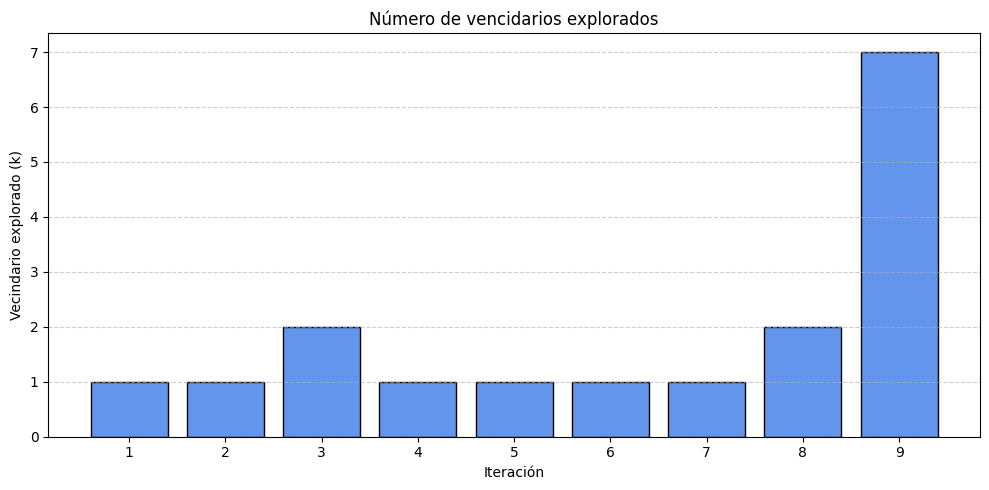

In [44]:
import matplotlib.pyplot as plt

def plot_vecindarios_por_iteracion(vecindarios, titulo=""):
    """
    Dibuja un gráfico de barras que muestra el vecindario explorado en cada iteración.

    :param vecindarios: lista o array con el número de vecindario explorado por iteración.
    :param titulo: título opcional para el gráfico.
    """
    iteraciones = list(range(1, len(vecindarios) + 1))

    plt.figure(figsize=(10, 5))
    plt.bar(iteraciones, vecindarios, color='cornflowerblue', edgecolor='black')

    plt.title(f"Número de vencidarios explorados")
    plt.xlabel("Iteración")
    plt.ylabel("Vecindario explorado (k)")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(iteraciones)
    plt.tight_layout()
    plt.show()


plot_vecindarios_por_iteracion(numero_vecindarios_antes_sol)

In [37]:
evals_vecindario

[573516,
 160321,
 173581,
 223569,
 191032,
 70230,
 218212,
 251060,
 165859,
 240348,
 8009,
 244815,
 376426,
 349676,
 285145,
 27864,
 306845,
 228489,
 71083,
 65528,
 404663,
 327549,
 116570,
 33004,
 337860,
 33156,
 83632]

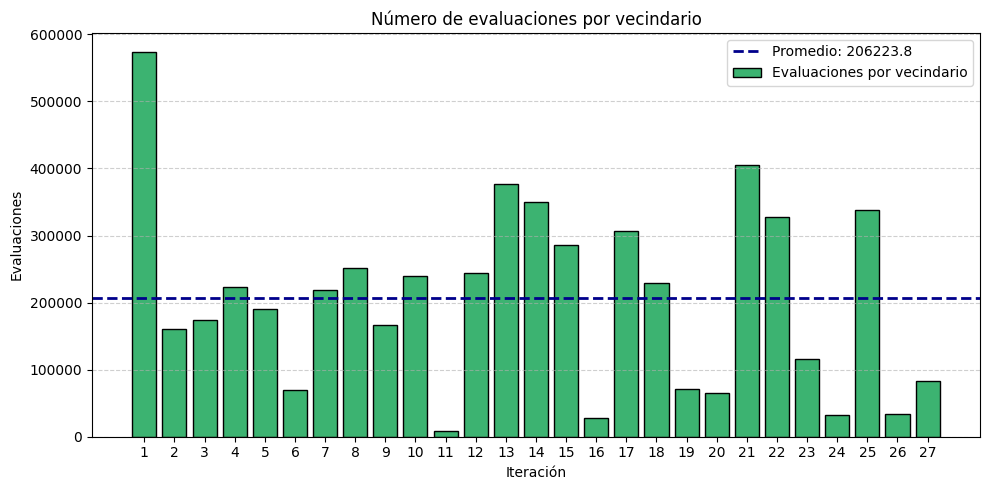

In [46]:
import matplotlib.pyplot as plt

def plot_evaluaciones_por_iteracion(evaluaciones):
    """
    Dibuja un gráfico de barras del número de evaluaciones por iteración,
    incluyendo una línea horizontal con el promedio.

    :param evaluaciones: lista o array con el número de evaluaciones por iteración.
    :param titulo: texto opcional que se añadirá al título del gráfico.
    """
    iteraciones = list(range(1, len(evaluaciones) + 1))
    media = np.mean(evaluaciones)

    plt.figure(figsize=(10, 5))
    plt.bar(iteraciones, evaluaciones, color='mediumseagreen', edgecolor='black', label="Evaluaciones por vecindario")
    plt.axhline(y=media, color='darkblue', linestyle='--', linewidth=2, label=f"Promedio: {media:.1f}")

    plt.title(f"Número de evaluaciones por vecindario")
    plt.xlabel("Iteración")
    plt.ylabel("Evaluaciones")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(iteraciones)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_evaluaciones_por_iteracion(evals_vecindario)

In [30]:
valores_vns

[117370,
 117300,
 117300,
 116988,
 116966,
 116868,
 116800,
 116550,
 116550,
 116534,
 116534,
 116534,
 116534,
 116534,
 116534,
 116534,
 116388,
 116388,
 116388,
 116388,
 116388,
 116388,
 116388,
 116388,
 116388,
 116388,
 116388]

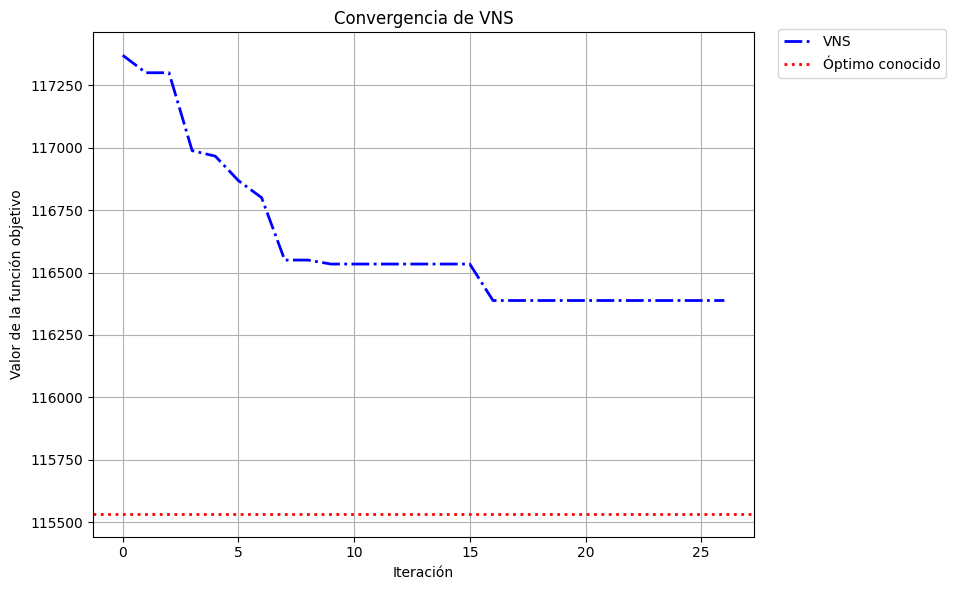

In [31]:
def plot_vns(optimo, valores):
    valores = np.array(valores)
    k_poblacion = 1
    n_iteraciones = valores.shape

    # Índice del mejor individuo según el valor final (última iteración)
    #indice_mejor = np.argmin(valores[-1, :])

    plt.figure(figsize=(10, 6))

    # Línea del promedio
    plt.plot(valores, label='VNS', color='blue', linewidth=2, linestyle='-.')

    # Línea del óptimo
    plt.axhline(optimo, color='red', linestyle=':', linewidth=2, label='Óptimo conocido')

    plt.xlabel('Iteración')
    plt.ylabel('Valor de la función objetivo')
    plt.title('Convergencia de VNS')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.02))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_vns(115534, np.array(valores_vns))